In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm
from sklearn.svm import SVC, LinearSVC , LinearSVR
from keras.layers import Dense , LSTM
from keras.models import Sequential
import tensorflow as tf
pd.set_option('max_columns', 30)
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 

# Importing Dataset FD001

In [24]:
def load_train_data(train_FD001):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\train_FD001'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data 

In [25]:
def load_test_data(FD001):
    data = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\test_FD001'  + '.txt', sep = ' ', header = None)
    data = data[list(range(0, 26))]
    data.rename(columns = {0 : 'unit', 1 : 'cycle'}, inplace = True)
    
    total_cycles = data.groupby(['unit']).agg({'cycle' : 'max'}).reset_index()
    total_cycles.rename(columns = {'cycle' : 'total_cycles'}, inplace = True)
    
    data = data.merge(total_cycles, how = 'left', left_on = 'unit', right_on = 'unit')
    
    RUL = pd.read_csv('C:\\Users\\dell\\Desktop\\Unicoverge Technologies\\Project\\Turbofan engine\\RUL_FD001' + '.txt', sep = ' ', header = None)
    RUL = RUL[list(range(0, 1))]
    RUL['unit'] = list(range(1, len(RUL) + 1))
    RUL.rename(columns = {0 : 'RUL'}, inplace = True)
    
    data = data.merge(RUL, how = 'left', left_on = 'unit', right_on = 'unit')
    
    data['total_cycles'] = data.apply(lambda r: int(r['total_cycles'] + r['RUL']), axis = 1)
    data['RUL'] = data.apply(lambda r: int(r['total_cycles'] - r['cycle']), axis = 1)
    
    return data

In [26]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    
    return (arr - mean) / std

In [27]:
def compute_score(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    
    return np.sum(np.exp(d[d >= 0] / 10) - 1) + np.sum(np.exp(-1 * d[d < 0] / 13) - 1)

def MSE(RUL_real, RUL_pred):
    d = RUL_pred - RUL_real
    return np.sqrt(np.sum(d ** 2)) / len(d)

def MAE(RUL_real, RUL_pred):
    return np.mean(np.abs(RUL_pred - RUL_real))

In [28]:
train_fd1 = load_train_data('FD001')
test_fd1 = load_test_data('FD001')

# Data Visualisation

In [29]:
train_fd1.describe()

,unit,cycle,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,total_cycles,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,216.615724,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,50.028600,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,128.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,185.000000,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,207.000000,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,240.000000,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,362.000000,361.000000


In [30]:
train_fd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 28 columns):
unit            20631 non-null int64
cycle           20631 non-null int64
2               20631 non-null float64
3               20631 non-null float64
4               20631 non-null float64
5               20631 non-null float64
6               20631 non-null float64
7               20631 non-null float64
8               20631 non-null float64
9               20631 non-null float64
10              20631 non-null float64
11              20631 non-null float64
12              20631 non-null float64
13              20631 non-null float64
14              20631 non-null float64
15              20631 non-null float64
16              20631 non-null float64
17              20631 non-null float64
18              20631 non-null float64
19              20631 non-null float64
20              20631 non-null float64
21              20631 non-null int64
22              20631 non-null int64
23

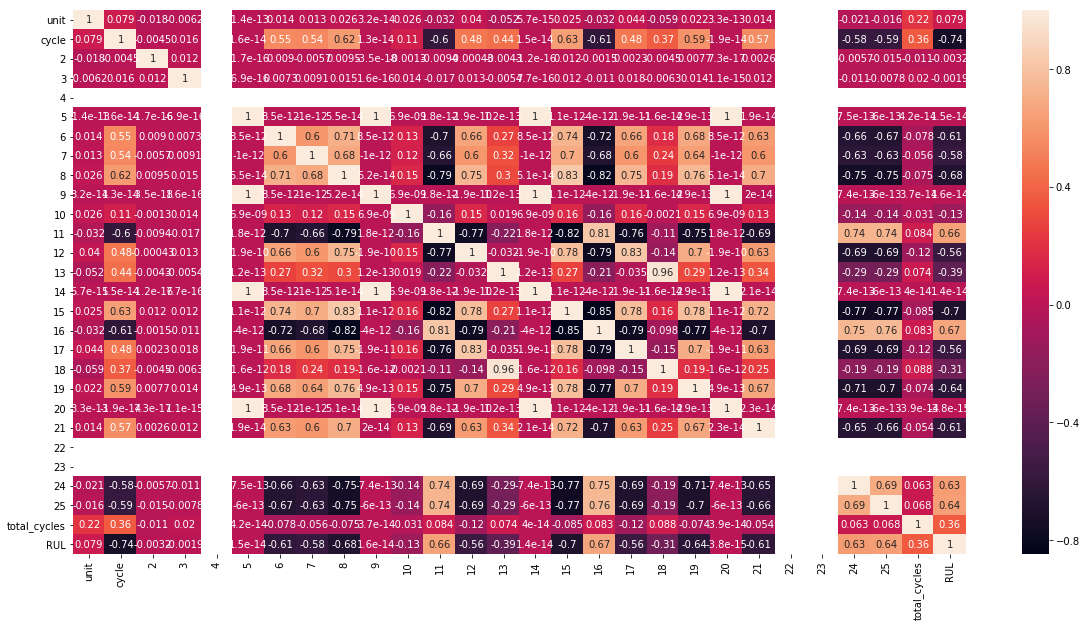

In [31]:
plt.figure(figsize=(20,10))
sns.heatmap(train_fd1.corr() , annot = True)

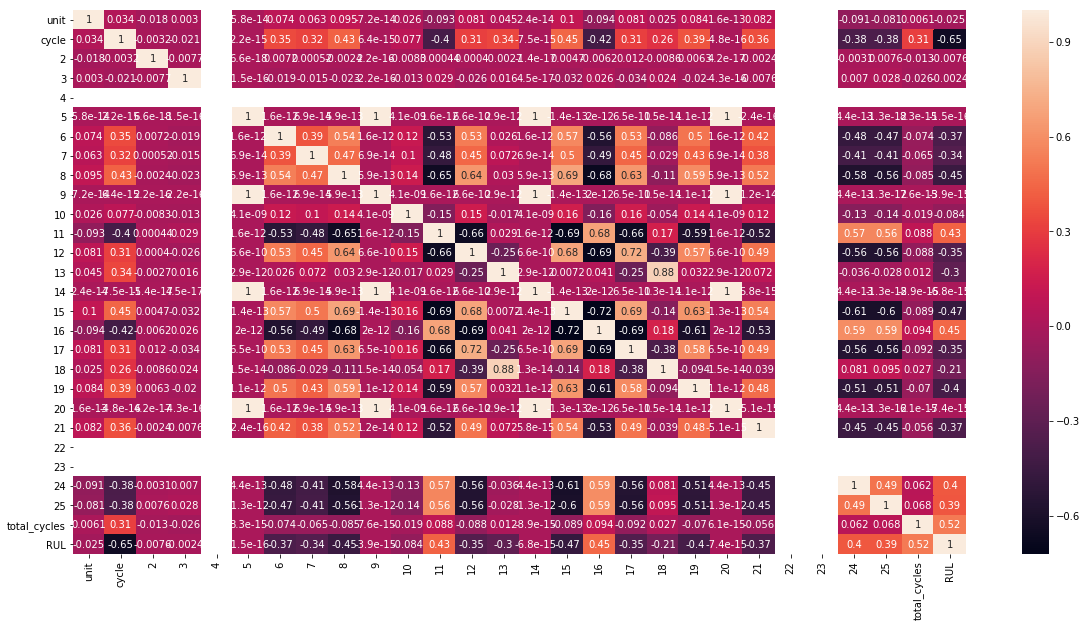

In [32]:
plt.figure(figsize=(20,10))
sns.heatmap(test_fd1.corr() , annot = True)

In [33]:
features = list(range(2, 26))

train_fd1[features] = train_fd1[features].apply(normalize, axis = 0)
test_fd1[features] = test_fd1[features].apply(normalize, axis = 0)

test_rows = test_fd1.groupby(['unit']).agg({'cycle' : max})
test_rows = test_rows.reset_index()
test_rows = test_rows.merge(test_fd1, how = 'left', left_on = ['unit', 'cycle'],
                                                    right_on = ['unit', 'cycle'])

In [34]:
y = train_fd1['RUL'].values

X_pred = test_rows[features].dropna(how = 'all', axis = 1)

X = train_fd1[features].dropna(how = 'all', axis = 1)



X = X.as_matrix()
X_pred = X_pred.as_matrix()
y_real = test_rows['RUL'].values

In [39]:
X_pred = np.delete(X_pred, 1, 1)
print(y.shape)
print(X.shape)
print(X_pred.shape)
print(y_real.shape)


(20631,)
(20631, 19)
(100, 19)
(100,)


In [40]:
feature_columns = [tf.feature_column.numeric_column("x", shape = [19])]

regressor = tf.estimator.DNNRegressor(feature_columns = feature_columns,
                                      hidden_units    = [15, 30, 15])

train_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": X},
                                                    y = np.array(y, dtype = np.int),
                                                    num_epochs = None,
                                                    shuffle = True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(x = {"x": np.array(X_pred)},
                                                      num_epochs = 1,
                                                      shuffle = False)

regressor.train(input_fn = train_input_fn, steps = 100)
y_pred = regressor.predict(predict_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\dell\\AppData\\Local\\Temp\\tmpg8q689jj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000014ED436B128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Checkpo

In [41]:
print(y_pred)

<generator object Estimator.predict at 0x0000014ED4365150>


In [42]:
y_pred = [val for val in y_pred]
y_pred = np.array(list(map(lambda x: x['predictions'][0], y_pred)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\dell\AppData\Local\Temp\tmpg8q689jj\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
print(y_pred)

[120.79074   93.957115  49.661877  55.21763   76.228584  89.210144
  66.18514   48.828053  59.667225  72.198044  72.27186   50.876316
  51.035572  98.2674   107.72729   82.68545   27.07843   31.172281
  84.70646   19.20946   64.22851  100.8111   114.57635   25.95044
 109.07719   72.72312   86.26514   53.708652  65.34947   41.126827
  17.812366  50.63711   70.42129   27.782616  25.072668  16.798529
  55.1145    33.79716   87.65403   20.703999  61.38688   34.750473
  33.481518  92.64255   34.40315   23.963829  92.032684  62.65889
  21.654926  67.68026   76.69083   26.643759  22.459532 113.74674
  98.394226  30.77776   63.554996  33.56456  112.9142    74.657036
  20.340296  24.148169  48.790546  34.29588  264.09927   23.130487
  97.00294   21.217167  87.94051   57.541275  70.38681   43.41213
 114.84567   41.27629  120.68749   22.30503   35.768005 126.07161
  83.106705  46.83518   20.61956   17.863354  84.03797   37.228226
  94.722115  43.275867  86.089066 109.02657   66.23128   44.70843
 

In [44]:
print(len(X))

20631


In [45]:
print(len(y))

20631


In [46]:
print(len(y_pred))
print(len(y_real))
len(y_real) == len(y_pred)

100
100


True

In [47]:
print(y_real)

[112  98  69  82  91  93  91  95 111  96  97 124  95 107  83  84  50  28
  87  16  57 111 113  20 145 119  66  97  90 115   8  48 106   7  11  19
  21  50 142  28  18  10  59 109 114  47 135  92  21  79 114  29  26  97
 137  15 103  37 114 100  21  54  72  28 128  14  77   8 121  94 118  50
 131 126 113  10  34 107  63  90   8   9 137  58 118  89 116 115 136  28
  38  20  85  55 128 137  82  59 117  20]


# Various Machine Learning Models for Prediction

# Neural Network Regressor

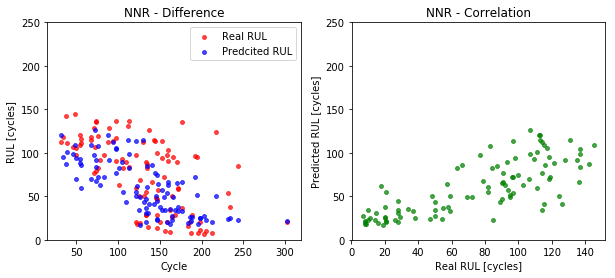

In [48]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('NNR - Difference')

axes[1].scatter(y_real, y_pred, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('NNR - Correlation')

axes[0].legend()

plt.show()

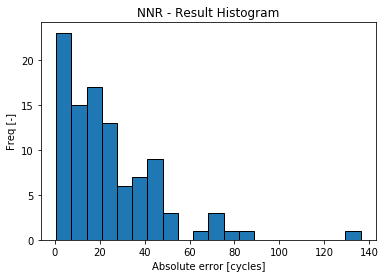

In [49]:
plt.hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('NNR - Result Histogram')
plt.show()

In [50]:
print('Average score per UUT:', compute_score(y_real, y_pred) / 100)
print('Mean squared Error:', MSE(y_real, y_pred))
print('Median difference:', np.median(np.abs(y_real - y_pred)))

Average score per UUT: 8170.862493561902
Mean squared Error: 3.305637622561906
Median difference: 20.054821014404297


# Support Vector Machine Regressor

In [51]:
model = svm.SVR()
model.fit(X, y)
y_pred_svm = model.predict(X_pred)

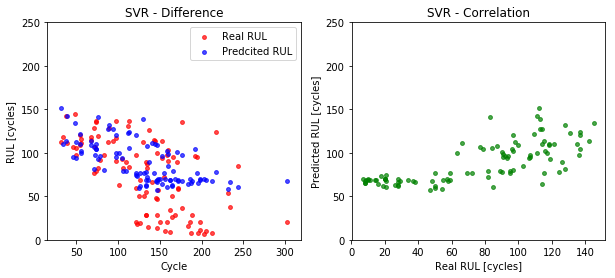

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_pred_svm, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('SVR - Difference')

axes[1].scatter(y_real, y_pred_svm, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('SVR - Correlation')

axes[0].legend()

plt.show()

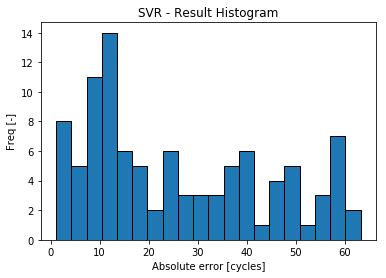

In [53]:
plt.hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('SVR - Result Histogram')
plt.show()

In [54]:
print('Average score per UUT:', compute_score(y_real, y_pred_svm) / 100)
print('Mean squared Error:', MSE(y_real, y_pred_svm))
print('Median difference:', np.median(np.abs(y_real - y_pred_svm)))

Average score per UUT: 59.867744217461016
Mean squared Error: 3.187607542604583
Median difference: 21.258174690088637


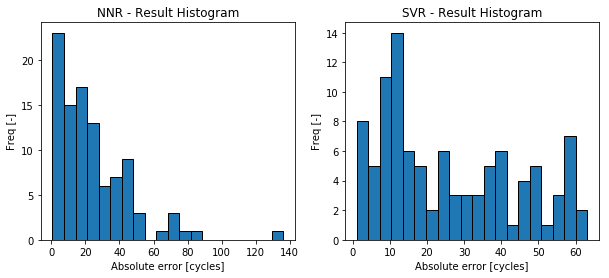

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axes[0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0].set_xlabel('Absolute error [cycles]')
axes[0].set_ylabel('Freq [-]')
axes[0].set_title('NNR - Result Histogram')

axes[1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[1].set_xlabel('Absolute error [cycles]')
axes[1].set_ylabel('Freq [-]')
axes[1].set_title('SVR - Result Histogram')
plt.show()

# Decision Tree Regressor

In [56]:
regr_1 = DecisionTreeRegressor(max_depth= 4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth= 4),
                          n_estimators=300, random_state = None)

regr_1.fit(X, y)
regr_2.fit(X, y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=None)

In [57]:
y_1 = regr_1.predict(X_pred)
y_2 = regr_2.predict(X_pred)

In [58]:
print(len(X))
print(len(y))
print(len(y_1))
print(len(y_2))
len(X) == len(y)

20631
20631
100
100


True

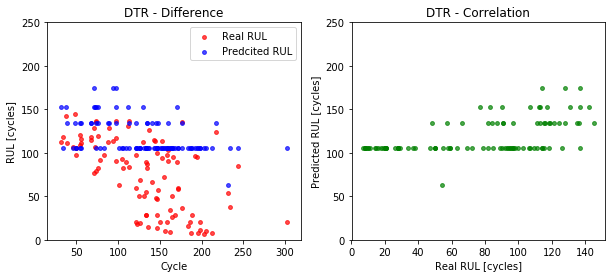

In [59]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_1, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTR - Difference')

axes[1].scatter(y_real, y_1, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTR - Correlation')

axes[0].legend()

plt.show()

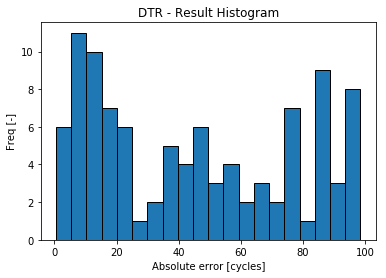

In [60]:
plt.hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTR - Result Histogram')
plt.show()

In [61]:
print('Average score per UUT:', compute_score(y_real, y_1) / 100)
print('Mean squared Error:', MSE(y_real, y_1))
print('Median difference:', np.median(np.abs(y_real - y_1)))

Average score per UUT: 2261.793380334326
Mean squared Error: 5.494036412179466
Median difference: 42.93154242954984


# Decision Tree Regressor using Adaboost

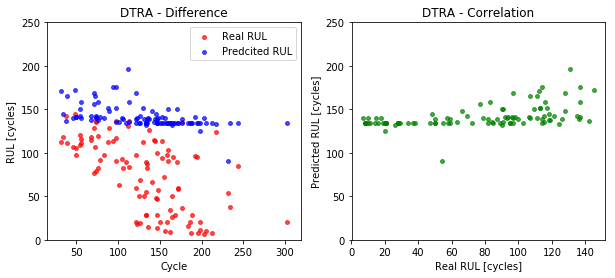

In [62]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_2, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('DTRA - Difference')

axes[1].scatter(y_real, y_2, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('DTRA - Correlation')

axes[0].legend()

plt.show()

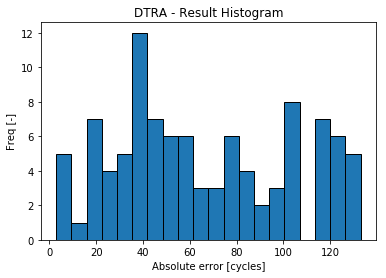

In [63]:
plt.hist(np.abs(y_real - y_2), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('DTRA - Result Histogram')
plt.show()

In [64]:
print('Average score per UUT:', compute_score(y_real, y_2) / 100)
print('Mean squared Error:', MSE(y_real, y_2))
print('Median difference:', np.median(np.abs(y_real - y_2)))

Average score per UUT: 45087.45122394163
Mean squared Error: 7.567030104664327
Median difference: 59.530357930237784


# KNN Regressor

In [65]:
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')

In [66]:
KNeighborsRegressor()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [67]:
y_3 = neigh.predict(X_pred)

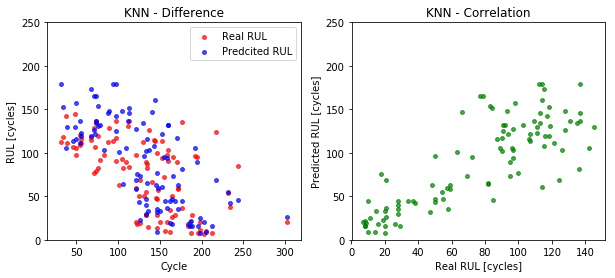

In [68]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_3, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('KNN - Difference')

axes[1].scatter(y_real, y_3, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('KNN - Correlation')

axes[0].legend()

plt.show()

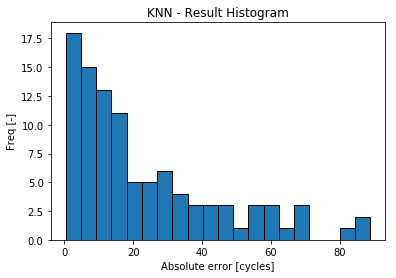

In [69]:
plt.hist(np.abs(y_real - y_3), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('KNN - Result Histogram')
plt.show()

In [70]:
print('Average score per UUT:', compute_score(y_real, y_3) / 100)
print('Mean squared Error:', MSE(y_real, y_3))
print('Median difference:', np.median(np.abs(y_real - y_3)))

Average score per UUT: 217.58673179396555
Mean squared Error: 3.1266252916340505
Median difference: 14.714285714285715


# Random Forest Regressor

In [71]:
regr1 = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
regr1.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [72]:
y_4 = regr1.predict(X_pred)

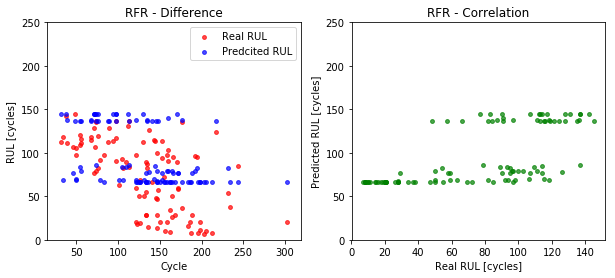

In [73]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axes[0].scatter(test_rows['cycle'], y_real, color = 'red', label = 'Real RUL', alpha = 0.7, s = 15)
axes[0].scatter(test_rows['cycle'], y_4, color = 'blue', label = 'Predcited RUL', alpha = 0.7, s = 15)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('RUL [cycles]')
axes[0].set_ylim([0, 250])
axes[0].set_title('RFR - Difference')

axes[1].scatter(y_real, y_4, color = 'green', alpha = 0.7, s = 15)
axes[1].set_xlabel('Real RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_ylim([0, 250])
axes[1].set_title('RFR - Correlation')

axes[0].legend()

plt.show()

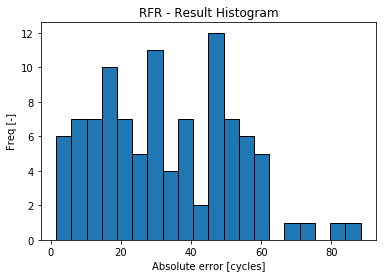

In [74]:
plt.hist(np.abs(y_real - y_4), bins = 20, edgecolor='black')
plt.xlabel('Absolute error [cycles]')
plt.ylabel('Freq [-]')
plt.title('RFR - Result Histogram')
plt.show()

In [75]:
print('Average score per UUT:', compute_score(y_real, y_4) / 100)
print('Mean squared Error:', MSE(y_real, y_4))
print('Median difference:', np.median(np.abs(y_real - y_4)))

Average score per UUT: 186.40851832889047
Mean squared Error: 3.8087618218480013
Median difference: 30.411956676994535


# Conclusion

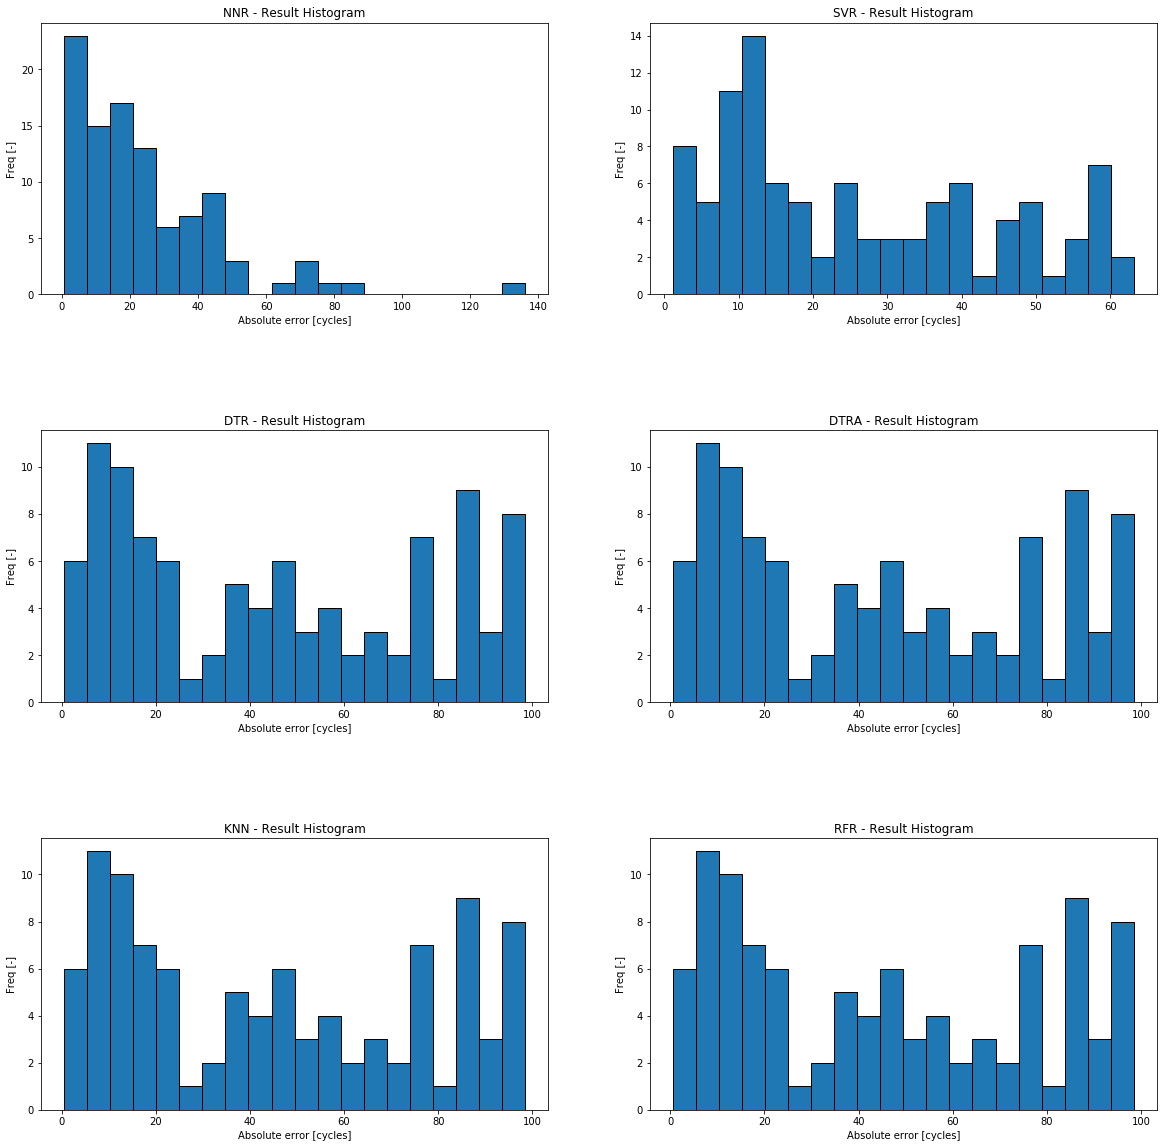

In [76]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
axes[0,0].hist(np.abs(y_real - y_pred), bins = 20, edgecolor='black')
axes[0,0].set_xlabel('Absolute error [cycles]')
axes[0,0].set_ylabel('Freq [-]')
axes[0,0].set_title('NNR - Result Histogram')

axes[0,1].hist(np.abs(y_real - y_pred_svm), bins = 20, edgecolor='black')
axes[0,1].set_xlabel('Absolute error [cycles]')
axes[0,1].set_ylabel('Freq [-]')
axes[0,1].set_title('SVR - Result Histogram')

axes[1,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,0].set_xlabel('Absolute error [cycles]')
axes[1,0].set_ylabel('Freq [-]')
axes[1,0].set_title('DTR - Result Histogram')

axes[1,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[1,1].set_xlabel('Absolute error [cycles]')
axes[1,1].set_ylabel('Freq [-]')
axes[1,1].set_title('DTRA - Result Histogram')

axes[2,0].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,0].set_xlabel('Absolute error [cycles]')
axes[2,0].set_ylabel('Freq [-]')
axes[2,0].set_title('KNN - Result Histogram')

axes[2,1].hist(np.abs(y_real - y_1), bins = 20, edgecolor='black')
axes[2,1].set_xlabel('Absolute error [cycles]')
axes[2,1].set_ylabel('Freq [-]')
axes[2,1].set_title('RFR - Result Histogram')

plt.show()